# 如何訓練小數據集

要用非常少的數據來訓練一個圖像分類的模型是一種在實務上常見的情況，如果您過去曾經進行過影像視覺處理的相關專案，這樣的情況勢必常常遇到。

訓練用樣本很"少"可以意味著從幾百到幾萬個圖像(視不同的應用與場景)。作為一個示範的案例，我們將集中在將圖像分類為“狗”或“貓”，數據集中包含4000張貓和狗照片（2000隻貓，2000隻狗）。我們將使用2000張圖片進行訓練，1000張用於驗證，最後1000張用於測試。

我們將回顧一個解決這種問題的基本策略：從零開始，我們提供了少量數據來訓練一個新的模型。我們將首先在我們的2000個訓練樣本上簡單地訓練一個小型卷積網絡(convnets)來做為未來優化調整的基準，在這過程中沒有任何正規化(regularization)的手法或配置。

這樣的模型將使我們的分類準確率達到71%左右。在這個階段，我們的主要問題將是過擬合(overfitting)。然後，我們將介紹*數據擴充(data augmentation)*，這是一種用於減輕電腦視覺演算過度擬合(overfitting)的強大武器。通過利用數據擴充(data augmentation)，我們將改進網絡，並提升準確率達到82%。

在另一個文章中，我們將探索另外兩種將深度學習應用到小數據集的基本技術:*使用預訓練的網絡模型來進行特徵提取*（這將使我們達到90%至93%的準確率），*調整一個預先訓練的網絡模型*（這將使我們達到95%的最終準確率）。
總而言之，以下三個策略: 

* 從頭開始訓練一個小型模型
* 使用預先訓練的模型進行特徵提取
* 微調預先訓練的模型

將構成您未來的工具箱，用於解決計算機視覺運算應用到小數據集的問題上。

![data augmentation](https://cdn-images-1.medium.com/max/800/1*H0V8WAX9nLEmiD7cd1twow.png)

In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Using TensorFlow backend.


Platform: Windows-10-10.0.15063-SP0
Tensorflow version: 1.4.0
Keras version: 2.0.9


## 資料集說明

我們將使用的數據集(貓與狗的圖片集)沒有被包裝Keras包裝發佈, 因此要自行另外下載。Kaggle.com在2013年底提供了這些數據來作為電腦視覺競賽題目。您可以從以下連結下載原始數據集：`https://www.kaggle.com/c/dogs-vs-cats/data`

圖片是中等解析度的彩色JPEG檔。他們看起來像這樣：

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

該原始數據集包含25,000張狗和貓的圖像（每個類別12,500個），大小為543MB（壓縮）。下載和解壓縮後，我們將創建一個包含三個子集的新數據集：一組包含每個類的1000個樣本的訓練集，每組500個樣本的驗證集，最後一個包含每個類的500個樣本的測試集。

## 資料準備

1. 從[Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)點擊`Download`下載圖像資料檔`training.zip`。
2. 在這個Jupyter Notebook所在的目錄下產生一個新的子目錄"data"。
3. 把從kaggle下載的資料檔複製到"data"的目錄裡頭。
4. 將`train.zip`解壓縮
  
最後你的目錄結構看起來像這樣:
```
xx-yyy.ipynb
data/
└── train/
    ├── cat.0.jpg
    ├── cat.1.jpg
    ├── ..
    └── dog.12499.jpg
```

In [2]:
import os

# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放coco圖像資料與標註資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

In [3]:
import os, shutil

# 原始數據集的路徑
original_dataset_dir = os.path.join(DATA_PATH, "train")

# 存儲小數據集的目錄
base_dir = os.path.join(DATA_PATH, "cats_and_dogs_small")
if not os.path.exists(base_dir): 
    os.mkdir(base_dir)

# 我們的訓練資料的目錄
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

# 我們的驗證資料的目錄
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir): 
    os.mkdir(validation_dir)

# 我們的測試資料的目錄
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)    

# 貓的圖片的訓練資料目錄
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# 狗的圖片的訓練資料目錄
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# 貓的圖片的驗證資料目錄
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# 狗的圖片的驗證資料目錄
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# 貓的圖片的測試資料目錄
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# 狗的圖片的測試資料目錄
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

In [4]:
# 複製前1000個貓的圖片到train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy first 1000 cat images to train_cats_dir complete!')

# 複製下500個貓的圖片到validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy next 500 cat images to validation_cats_dir complete!')

# 複製下500個貓的圖片到test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy next 500 cat images to test_cats_dir complete!')

# 複製前1000個狗的圖片到train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy first 1000 dog images to train_dogs_dir complete!')


# 複製下500個狗的圖片到validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

print('Copy next 500 dog images to validation_dogs_dir complete!')

# C複製下500個狗的圖片到test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)
    
print('Copy next 500 dog images to test_dogs_dir complete!')

Copy first 1000 cat images to train_cats_dir complete!
Copy next 500 cat images to validation_cats_dir complete!
Copy next 500 cat images to test_cats_dir complete!
Copy first 1000 dog images to train_dogs_dir complete!
Copy next 500 dog images to validation_dogs_dir complete!
Copy next 500 dog images to test_dogs_dir complete!


作為一個健康檢查，讓我們計算每次訓練分組中有多少張照片（訓練/驗證/測試）:

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


所以我們確實有2000個訓練圖像，然後是1000個驗證圖像和1000個測試圖像。在每個資料分割(split)中，每個分類都有相同數量的樣本：這是一個平衡的二元分類問題，這意味著分類準確度將成為適當的度量。

## 資料預處理 (Data Preprocessing)

如現在已經知道的那樣，數據應該被格式化成適當的預處理浮點張量，然後才能餵進我們的神經網絡。目前，我們的數據是在檔案目裡裡的JPEG影像文件，所以進入我們網絡的前處理步驟大概是：

* 讀進圖像檔案。
* 將JPEG內容解碼為RGB網格的像素。
* 將其轉換為浮點張量。
* 將像素值（0和255之間）重新縮放到[0,1]間隔（如您所知，神經網絡更喜歡處理小的輸入值）。

這可能看起來有點令人生畏，但感謝Keras有一些工具程序可自動處理這些步驟。 Keras有一個圖像處理助手工具的模塊，位於`keras.preprocessing.image`。其中的`ImageDataGenerator`類別，可以快速的自動將磁盤上的圖像文件轉換成張量(tensors)。我們將在這裡使用這個工具。

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# 所有的圖像將重新被進行歸一化處理 Rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 直接從檔案目錄讀取圖像檔資料
train_generator = train_datagen.flow_from_directory( 
        # 這是圖像資料的目錄
        train_dir,
        # 所有的圖像大小會被轉換成150x150
        target_size=(150, 150),
        # 每次產生20圖像的批次資料
        batch_size=20,
        # 由於這是一個二元分類問題, y的lable值也會被轉換成二元的標籤
        class_mode='binary')

# 直接從檔案目錄讀取圖像檔資料
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


我們來看看這些圖像張量產生器(generator)的輸出：它產生150×150 RGB圖像（形狀“（20,150,150,3）”）和二進制標籤（形狀“（20，）”）的批次張量。 20是每個批次中的樣品數（批次大小）。請注意，產生器可以無限制地產生這些批次：因為它只是持續地循環遍歷目標文件夾中存在的圖像。因此，我們需要在某些時候`break`迭代循環。

In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


讓我們將模型與使用圖像張量產生器的數據進行訓練。我們使用`fit_generator`方法。

因為數據是可以無休止地持續生成，所以圖像張量產生器需要知道在一個訓練循環(epoch)要從圖像張量產生器中抽取多少個資料。這是`steps_per_epoch`參數的作用：在從生成器中跑過`steps_per_epoch`批次之後，即在運行`steps_per_epoch`梯度下降步驟之後，訓練過程將轉到下一個循環(epoch)。在我們的情況下，批次是20個樣本，所以它需要100次，直到我們的模型讀進了2000個目標樣本。

當使用`fit_generator`時，可以傳遞一個`validation_data`參數，就像`fit`方法一樣。重要的是，這個參數被允許作為數據生成器本身，但它也可以是一個Numpy數組的元組。如果您將生成器傳遞為`validation_data`，那麼這個生成器有望不斷生成一批驗證數據，因此您還應該指定`validation_steps`參數，該參數告訴進程從驗證生成器中抽取多少批次以進行評估。

## 網絡模型 (Model)

我們的卷積網絡(convnets)將是一組交替的`Conv2D`（具有`relu`激活）和`MaxPooling2D`層。
我們從大小150x150（有點任意選擇）的輸入開始，我們最終得到了尺寸為7x7的`Flatten`層之前的特徵圖。

注意，特徵圖的深度在網絡中逐漸增加（從32到128），而特徵圖的大小正在減少（從148x148到7x7）。這是一個你將在幾乎所有的卷積網絡(convnets)建構中會看到的模式。

由於我們正在處理二元分類問題，所以我們用一個神經元（一個大小為1的`密集層(Dense)`）和一個`sigmoid`激活函數來結束網絡。該神經元將會被用來查看圖像歸屬於那一類或另一類的機率。

In [8]:
from keras import layers
from keras import models
from keras.utils import plot_model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

我們來看看特徵圖的尺寸如何隨著每個連續的圖層而改變：

In [9]:
# 打印網絡結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

在我們的編譯步驟裡，我們使用`RMSprop`優化器。由於我們用一個單一的神經元(`Sigmoid`的激活函數)結束了我們的網絡，我們將使用`二進制交叉熵(binary crossentropy)`作為我們的損失函數。

In [10]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## 訓練 (Training)

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 11s 112ms/step - loss: 0.6955 - acc: 0.5295 - val_loss: 0.6809 - val_acc: 0.5340
Epoch 2/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6572 - acc: 0.6135 - val_loss: 0.6676 - val_acc: 0.5710
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6214 - acc: 0.6590 - val_loss: 0.6408 - val_acc: 0.6290
Epoch 4/30
100/100 [==============================] - 8s 77ms/step - loss: 0.5882 - acc: 0.6920 - val_loss: 0.6296 - val_acc: 0.6440
Epoch 5/30
100/100 [==============================] - 8s 77ms/step - loss: 0.5517 - acc: 0.7130 - val_loss: 0.7241 - val_acc: 0.5950
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.5108 - acc: 0.7530 - val_loss: 0.5785 - val_acc: 0.7010
Epoch 7/30
100/100 [==============================] - 8s 78ms/step - loss: 0.4899 - acc: 0.7680 - val_loss: 0.5620 - val_acc: 0.7060
Epoch 8/30
100/100 [==============================] - 8s 76ms/step 

訓練完後就把模型保存是個好習慣：

In [12]:
model.save('cats_and_dogs_small_2.h5')

讓我們使用圖表來秀出在訓練過程中模型對訓練和驗證數據的損失(loss)和準確性(accuracy)數據:

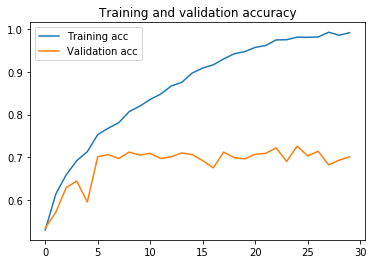

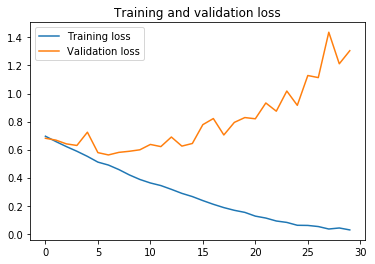

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

這些圖表顯示了過度擬合(overfitting)的特徵。我們的訓練精確度隨著時間線性增長，直到接近100%，然而我們的驗證精確度卻停在70 ~ 72%。我們的驗證損失在第五個循環(epochs)之後達到最小值，然後停頓，而訓練損失在線性上保持直到達到接近0。

因為我們只有相對較少的訓練數據（2000筆），過度擬合(overfitting)將成為我們的首要的關注點。您已經知道了許多可以幫助減輕過度擬合的技術，例如Dropout和權重衰減（L2正規化）。我們現在要引入一個新的，特定於電腦視覺影像，並在使用深度學習模型處理圖像時幾乎普遍使用的技巧：*數據擴充(data augmentation)*。

## 使用數據擴充

過度擬合(overfitting)是由於樣本數量太少而導致的，導致我們無法訓練能夠推廣到新數據的模型。

給定無限數據，我們的模型將暴露在手頭的數據分佈的每個可能的方面：我們永遠不會過度的。數據增加採用從現有訓練樣本生成更多訓練數據的方法，通過產生可信的圖像的多個隨機變換來“增加”樣本。目標是在訓練的時候，我們的模型永遠不會再看到完全相同的畫面兩次。這有助於模型暴露於數據的更多方面，並更好地推廣。

在Keras中，可以通過配置對我們的ImageDataGenerator實例讀取的圖像執行多個隨機變換來完成。讓我們開始一個例子：

In [14]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

這些只是列出一些可用的選項（更多選項資訊，請參閱Keras文檔）。我們快速看一下這些參數：

* `rotation_range`是以度（0-180）為單位的值，它是隨機旋轉圖片的範圍。
* `width_shift`和`height_shift`是范圍（佔總寬度或高度的一小部分），用於縱向或橫向隨機轉換圖片。
* `shear_range`用於隨機剪切變換。
* `zoom_range`用於隨機放大圖片內容。
* `horizontal_flip`用於在沒有水平不對稱假設（例如真實世界圖片）的情況下水平地隨機翻轉一半圖像。
* `fill_mode`是用於填充新創建的像素的策略，可以在旋轉或寬/高移位後顯示。

我們來看看我們的增強後的圖像：

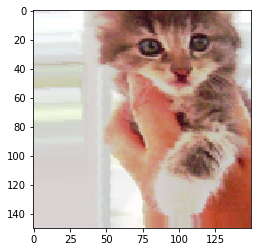

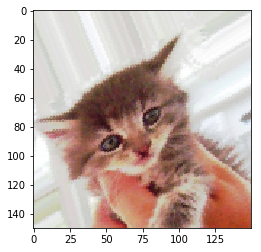

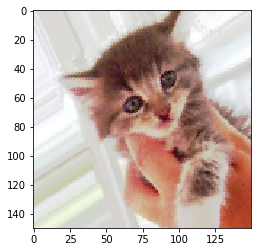

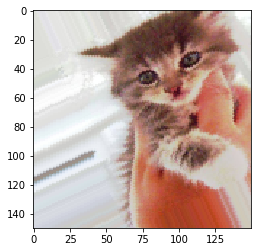

In [15]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
# 取得訓練資料集中貓的檔案列表
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# 取一個圖像
img_path = fnames[3]

# 讀圖像並進行大小處理
img = image.load_img(img_path, target_size=(150, 150))

# 轉換成Numpy array並且shape (150, 150, 3)
x = image.img_to_array(img)

# 重新Reshape成 (1, 150, 150, 3)以便輸入到模型中
x = x.reshape((1,) + x.shape)

# 透過flow()方法將會隨機產生新的圖像
# 它會無限循環，所以我們需要在某個時候“斷開”循環
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

如果我們使用這種數據增強配置來訓練一個新的網絡，我們的網絡將永遠不會看到相同重覆的輸入。然而，它看到的輸入仍然是相互關聯的，因為它們來自少量的原始圖像 - 我們不能產生新的信息，我們只能重新混合現有的信息。因此，這可能不足以完全擺脫過度擬合(overfitting)。為了進一步打擊過度擬合(overfitting)，我們還將在密集連接(densely-connected)的分類器之前添加一個Dropout層：

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

我們使用數據擴充(data augmentation)和dropout來訓練我們的網絡：

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 這是圖像資料的目錄
        train_dir,
        # 所有的圖像大小會被轉換成150x150
        target_size=(150, 150),
        batch_size=32,
        # 由於這是一個二元分類問題, y的lable值也會被轉換成二元的標籤
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 21s 208ms/step - loss: 0.6937 - acc: 0.5078 - val_loss: 0.6878 - val_acc: 0.4848
Epoch 2/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6829 - acc: 0.5572 - val_loss: 0.6779 - val_acc: 0.5647
Epoch 3/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6743 - acc: 0.5816 - val_loss: 0.6520 - val_acc: 0.6136
Epoch 4/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6619 - acc: 0.6122 - val_loss: 0.6348 - val_acc: 0.6218
Epoch 5/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6448 - acc: 0.6338 - val_loss: 0.6166 - val_acc: 0.6428
Epoch 6/50
100/100 [==============================] - 19s 187ms/step - loss: 0.6342 - acc: 0.6453 - val_loss: 0.6137 - val_acc: 0.6656
Epoch 7/50
100/100 [==============================] - 19s 189ms/step - loss: 0.6255 - acc: 0.6525 - val_lo

我們來保存我們的模型 - 我們將在convnet可視化裡使用它。

In [20]:
model.save('cats_and_dogs_small_2.h5')

我們再來看一遍我們的結果：

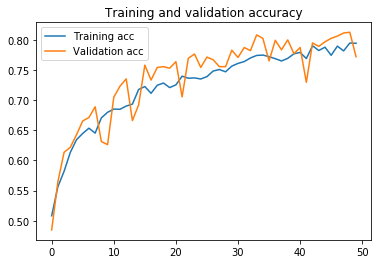

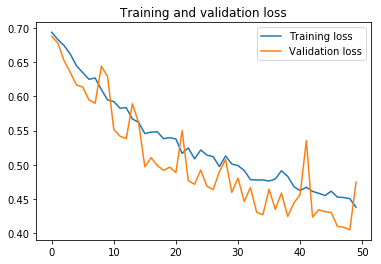

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

由於數據增加(data augmentation)和丟棄(dropout)的使用，我們不再有過度擬合(overfitting)的問題：訓練曲線相當密切地跟隨著驗證曲線。我們現在能夠達到82%的準確度，比非正規化的模型相比改善了15%。

通過進一步利用正規化技術，及調整網絡參數（例如每個卷積層的濾波器數量或網絡層數），我們可以獲得更好的準確度，可能高達86 ~ 87%。然而，只要我們從頭開始訓練我們自己的卷積網絡(convnets)，我們可以證明使用這麼少的數據要來訓練出一個準確率高的模型是非常困難的。為了繼續提高我們模型對這個問題的準確性，下一步我們將利用預先訓練的模型(pre-trained model)來進行操作。

###  總結
在這篇文章中有一些個人學習到的一些有趣的重點:
* 善用數據擴充(Data Augmentation)對訓練資料不多的圖像辨識可以提升效能
* Dropout的使用可以抑制過擬合(overfitting)的問題

參考: 
* [fchollet: deep-learning-with-python-notebooks](5.2-using-convnets-with-small-datasets.ipynb)
* [Keras官網](http://keras.io/)

MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.